In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Gang:
    """
    z: sites
    n: turns
    alpha: gang's propensity to crime
    g:  initial gang population at each site
    s:  gang concentration at each site
    """
    def __init__(self, z=2, n=10, alpha = 0.1, g = None, s=None):
        self.z = z
        self.n = n
        self.alpha = alpha
        
        self.g = np.ones(z) if g is None else g
        self.s = np.zeros(z) if s is None else s
        # initialize grid
        self.G = np.zeros((n,z))
        self.G[0] = self.g
        
    def draw(self):
        a = self.G
        plt.imshow(a, cmap='magma', alpha=0.7)
        plt.xticks([])
        plt.yticks([])
        
    def graph(self):
        G = self.G
        z = self.z
        n = self.n
        colors = 'brgcmyk'
        fig, ax = plt.subplots()
        for i in range(z):
            ax.plot(range(n), G[:, i], '-' + colors[i % len(colors)],
                    label='site ' + str(i))
        ax.set(title='Gang 1')
        leg = ax.legend()
       
        
class Hood1DG:
    """
    z: sites
    n: turns
    gang_count: number of gangs in hood
    gang_list: optional list of gang objects
    p: police presence in each site
    beta: arrest rate
    gamma: police reactivity
    delta: violence coefficient
    """
    def __init__(self, z=2, n=10, gang_count=1, gang_list=None,
                 p=None, beta=0.1, gamma=0.5, delta=0.1):
        self.z = z
        self.n = n
        self.gang_count = gang_count
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        
        self.p = np.ones(z) if p is None else p
        
        # initialize grids:
        # police
        self.P = np.zeros((n, z))
        # crime
        self.C = np.zeros((n, z))
        # arrests
        self.A = np.zeros((n, z))
        # violence
        self.V = np.zeros((n, z))
        
        # initialize gang list
        if gang_list is None:
            self.gangs = []
            for i in range(gang_count):
                self.gangs.append(Gang(z=z, n=n))
        else:
            self.gangs = gang_list
            
        # crime at site = sum(gang pop. * gang alpha) over z
        for k in range(gang_count):
            self.C[0] += self.gangs[k].G[0] * self.gangs[k].alpha
        # establish initial police levels based on crime levels
        self.P[0] = self.p + self.gamma * self.C[0]
        # calculate initial violence levels based on numbers of 
        # gang rivals occupying same site
        sums = np.zeros(self.z)
        for k in range(self.gang_count):
            for l in range(self.gang_count):
                if l != k:
                    sums += self.gangs[k].G[0] * self.gangs[l].G[0]
        sums = .5 * sums
        self.V[0] = self.delta * sums
            
        self.t = 0
        
    def step(self):
        t = self.t
        # reduce gang populations by arrests
        for k in range(self.gang_count):
            gang = self.gangs[k]
            arrests = self.beta * gang.G[t] * self.P[t]
            self.A[t] += arrests
            gang.G[t+1] = gang.G[t] - arrests
        # account for movement between sites
        for k in range(self.gang_count):
            gang = self.gangs[k]
            g_ = gang.G[t+1].copy()
            gang.G[t+1] *= 0
            for i in range(self.z):
                gang.G[t+1] += g_[i] * self.PI_k_ij(k,i)
        # add source terms
        for k in range(self.gang_count):
            gang = self.gangs[k]
            gang.G[t+1] += gang.s
        # update crime grid based on gang figures
        # just calculated
        for k in range(self.gang_count):
            gang = self.gangs[k]
            self.C[t+1] += gang.G[t+1] * gang.alpha
        # calculate violence based on numbers of rival
        # gang members occupying the same site
        sums = np.zeros(self.z)
        for k in range(self.gang_count):
            for l in range(self.gang_count):
                if l != k:
                    sums += self.gangs[k].G[t+1] * self.gangs[l].G[t+1]
        sums = .5 * sums
        self.V[t+1] = self.delta * sums
        
        # update police numbers
        self.P[t+1] = self.p + self.gamma * self.C[t+1]
            
        self.t += 1
        
    def PI_k_ij(self, k, i):
        """ 
        transition function: 
        For gang k at site i, returns array of
        length z containing probabilities of transition
        from i to each site
        """
        t = self.t
        # count rival gang members in each site
        rivals = np.zeros(self.z)
        for l in range(self.gang_count):
            if l != k:
                rivals += self.gangs[l].G[t]
        # compute difference of (cops + rivals) between
        # i and every site
        p_ = self.P[t]
        x = (p_[i] + rivals[i]) - (p_ + rivals)
        # find ln(1+e^x) for each entry
        x = np.log(1 + np.exp(x))
        return x / x.sum()
      
    def loop(self):
        for i in range(self.n - 1):
            self.step()
            
    def draw(self):
        crime = self.C
        plt.imshow(crime, cmap='plasma')
        plt.xticks([])
        plt.yticks([])
        
    def draw_V(self):
        violence = self.V
        plt.imshow(violence, cmap='plasma')
        plt.xticks([])
        plt.yticks([])
        
        
    def graph(self):
        crime = self.C
        z = self.z
        n = self.n
        colors = 'brgcmyk'
        fig, ax = plt.subplots()
        for i in range(z):
            ax.plot(range(n), crime[:, i], 
                    '-' + colors[i % len(colors)],
                    label='site ' + str(i))
        ax.set(title='Crime by site')
        leg = ax.legend()
    
    def graph_V(self):
        violence = self.V
        z = self.z
        n = self.n
        colors = 'brgcmyk'
        fig, ax = plt.subplots()
        for i in range(z):
            ax.plot(range(n), violence[:, i], 
                    '-' + colors[i % len(colors)],
                    label='site ' + str(i))
        ax.set(title='Violence by site')
        leg = ax.legend()

In [2]:

bloods = Gang(z=5, n=20, alpha=0.1, g=np.array([1,6,1,0,1]), s=np.array([0, 2, 0, 0, 0]))
crips = Gang(z=5, n=20, alpha=0.3, g=np.array([1,0,4,1,1]), s=np.array([0, 0, 2, 0, 0]))
hood= Hood1DG(z=5,n=20, gang_count=2, gang_list=[bloods, crips], p=np.array([3,1,2,2,2]), beta=0.1, gamma=0.5)
hood.loop()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


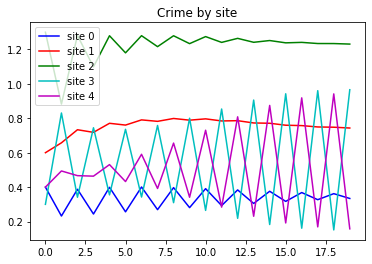

In [5]:
hood.graph()
plt.savefig('gang_fig3', format='eps')

In [8]:
bloods = Gang(z=3, n=100, alpha=0.1, g=np.array([1,6,1]), s=np.array([2, 0, 0]))
crips = Gang(z=3, n=100, alpha=0.3, g=np.array([1,0,4]), s=np.array([0, 2, 0]))
hood= Hood1DG(z=3,n=100, gang_count=2, gang_list=[bloods, crips], p=np.array([3,1,2]), beta=0.1, gamma=0.5)
hood.loop()

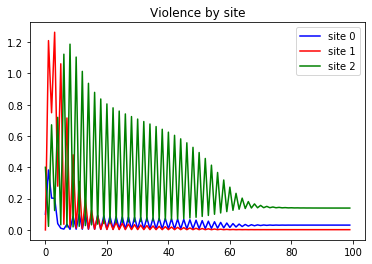

In [9]:
hood.graph_V()

In [11]:
b0 = bloods.G[80].copy()
c0 = crips.G[80].copy()

In [15]:
# double growth rate
bloods = Gang(z=3, n=100, alpha=0.1, g=b0, s=np.array([2, 0, 0]))
crips = Gang(z=3, n=100, alpha=0.3, g=c0, s=np.array([0, 4, 0]))
hood= Hood1DG(z=3,n=100, gang_count=2, gang_list=[bloods, crips], p=np.array([3,1,2]), beta=0.1, gamma=0.5)
hood.loop()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


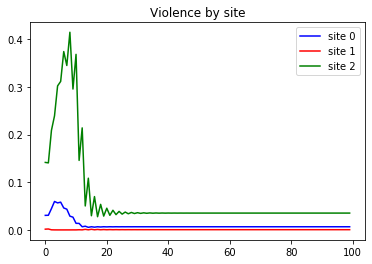

In [26]:
hood.graph_V()
plt.savefig('gang_fig4.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


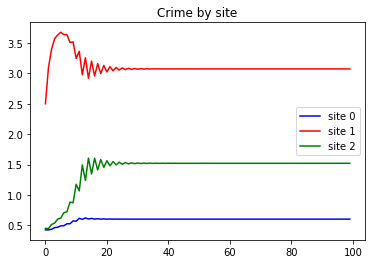

In [27]:
hood.graph()
plt.savefig('gang_fig5.eps', format='eps')

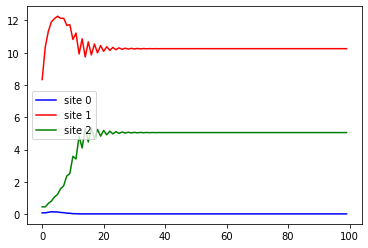

In [25]:
crips.graph()